# Tensorflow tutorial

## Import libraries

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.16.1


## Set random state

In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Load the data

In [4]:
data_dir = "./data/aclImdb"

In [5]:
raw_training_set = tf.keras.utils.text_dataset_from_directory(
    f"{data_dir}/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.


In [6]:
raw_validation_set = tf.keras.utils.text_dataset_from_directory(
    f"{data_dir}/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


In [7]:
raw_test_set = tf.keras.utils.text_dataset_from_directory(
    f"{data_dir}/test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
)

Found 5000 files belonging to 2 classes.


## Investigate data

In [8]:
print(f"Label 0 corresponds to {raw_training_set.class_names[0]}")
print(f"Label 1 corresponds to {raw_training_set.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


### Take one batch and investigate

In [9]:
for text_batch, label_batch in raw_training_set.take(1):
    for text, label in list(zip(text_batch, label_batch))[:3]:
        print(f"Label: {label}")
        print(f"Text:\n {text}")
        print("---------------------------")

Label: 1
Text:
 b'This is a reunion, a team, and a great episode of Justice. From hesitation to resolution, Clark has made a important leap from a troubled teenager who was afraid of a controlled destiny, to a Superman who, like Green Arrow, sets aside his emotions to his few loved ones, ready to save the whole planet. This is not just a thrilling story about teamwork, loyalty, and friendship; this is also about deciding what\'s more important in life, a lesson for Clark. I do not want the series to end, but I hope the ensuing episodes will strictly stick to what Justice shows without any "rewind" pushes and put a good end here of Smallville---and a wonderful beginning of Superman.<br /><br />In this episode, however, we should have seen more contrast between Lex and the Team. Nine stars should give it enough credit.'
---------------------------
Label: 1
Text:
 b'"Hey Babu Riba" is a film about a young woman, Mariana (nicknamed "Esther" after a famous American movie star), and four you

## Prepare the data

### Create custom function for cleaning input data

In [10]:
max_features = 1000


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    replaced = tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )
    return replaced

### Layer to convert text to vectors

In [11]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=250,
)

### Build vocabulary

As the `raw_training_set` consist of both text and the labels and the `adapt` method of the `TextVectorization` class only takes the input text, we need to strip out the labels.

In [12]:
train_text = raw_training_set.map(
    lambda x, y: x
)  # Extracts only the text from a item that corresponds to text, label

In [13]:
vectorize_layer.adapt(train_text)

In [14]:
print(f"Vocabulary samples: {vectorize_layer.get_vocabulary()[0:20]}")

Vocabulary samples: ['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film']


In [15]:
print(f"Vocabulary length: {len(vectorize_layer.get_vocabulary())}")

Vocabulary length: 1000


### Accomodate for batches by adding a dimension to dataset

In [16]:
def vectorize_text(text, label):
    # Just transforms the data from a (x,) shape to (x, 1) shape as this is that the TextVectorization expects
    text = tf.expand_dims(text, -1)
    return (
        vectorize_layer(text),
        label,
    )  # vectorize_layer takes one batch of size [32,1] and returns [32, 250] i.e string -> tokens

In [17]:
text_batch, label_batch = next(iter(raw_training_set))
first_review, first_label = text_batch[0], label_batch[0]

In [18]:
print(f"First review:\n:{first_review}")
print("---------------")
print(f"First label: {first_label}")
print("---------------")
print(f"Vectorized review 1:\n{vectorize_text(first_review, first_label)}")
print("---------------")

First review:
:b"This movie is about a side of Ireland that Americans don't normally see, the narrow-minded religiously prejudiced side of the 'friendliest race in the world'. The movie, by the admission of the inhabitants of Fethard who are old enough to remember the events, is fairly accurate (though they insist that the film-makers invented some of the more violent scenes just to spice up the action).<br /><br />The movie was very unpopular in Ireland as it portrayed the Catholic church in a bad light, but the simple fact is that representatives of the Catholic church *did* organise vetoes of minorities (before Protestants it was the Jews).<br /><br />The film is a fascinating insight into the whole issue of religion in Ireland"
---------------
First label: 1
---------------
Vectorized review 1:
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 10,  17,   7,  42,   3, 421,   5,   1,  12,   1,  87,   1,  65,
          2,   1,   1,   1, 421,   5,   2,   1,   1,   8,   2, 185, 

### Create final train/val/test set

In [19]:
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

### Configure dataset

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create a sequential model

### Exploring the Sequential Model Architecture

This TensorFlow model is structured to process sequences of text data by embedding tokens, averaging these embeddings, and finally classifying the averaged embeddings. Here's a detailed breakdown of each layer and its function within the model.

#### 1. Embedding Layer

```python
layers.Embedding(max_features, embedding_dim)
```

**Purpose:** The Embedding layer is essential for handling large vocabularies in natural language processing. It maps each token, represented as an integer index, to a dense vector of fixed size `(embedding_dim)`.

**Input:** The input to this layer is a batch of sequences, where each sequence contains indices ranging from `0` to `max_features - 1`. Each index corresponds to a token in the vocabulary.

**Output Shape:** `[32, 250, 16]`. Each token in a sequence of 250 tokens (maximum sequence length) is transformed into an embedding of 16 dimensions. Therefore, a batch of 32 sequences results in an output tensor of shape `[32, 250, 16]`.

The Embedding layer plays a crucial role in natural language processing models by transforming discrete, categorical data (token indices) into dense and continuous vectors. Here's how it processes a batch of input data:

##### Input Data Structure

- **Shape**: `[32, 250]`. This represents a batch where there are 32 sequences (such as sentences or paragraphs), and each sequence contains 250 tokens. These tokens are represented by integer indices that refer to a position in the model's vocabulary.
- **Content**: Each entry in the batch is an integer between 0 and `max_features - 1`, where each integer corresponds to a unique token in the predefined vocabulary of the model.

##### Embedding Layer Functionality

- Configuration:
    - max_features: The size of the vocabulary. This is the maximum number of distinct tokens that the model can handle.
    - embedding_dim: The dimensionality of the embedding vectors. This parameter defines how many features each token will be represented with after passing through the Embedding layer.

- Operation:
    - When the input data (with indices) passes through the Embedding layer, each token index is looked up in an embedding matrix (of shape [max_features, embedding_dim]).
    - This matrix contains a unique vector for each token index. The layer retrieves a specific vector for each token index found in the input batch.

- Output:
    - The result is a tensor of shape [32, 250, 16]. Here’s the breakdown:
        - 32 corresponds to the number of sequences in the batch.
        - 250 corresponds to the number of tokens per sequence.
        - 16 is the embedding dimension, indicating that each token index from the input has been transformed into a 16-dimensional vector.

##### Resulting Transformation
The transformation from sparse indices to dense vectors enables the model to perform more nuanced and complex operations on the data. Each embedding vector captures semantic and syntactic properties of its corresponding token, allowing the model to understand and process language data more effectively.

The output tensor from the Embedding layer now carries a rich representation of each token based on the learned embeddings, which significantly enhances the model's capability to capture relationships and patterns in the text data.
This interaction between the input batch and the Embedding layer is fundamental in preparing the text data for subsequent layers and tasks in the model, such as classification, sentiment analysis, or language translation.



In [21]:
embedding_dim = 16

# Input for one batch: [32, 250]. Values are idx in the vocabulary
model_sequential = tf.keras.Sequential(
    [
        # Shape [1000, 16].
        layers.Embedding(max_features, embedding_dim),
        # Output from Embedding layer is [32, 250, 16] (it just pulls an embedding vector for all values)
        layers.GlobalAveragePooling1D(),
        # Output from Pooling layer. It goes from representing one embedding vector per token to one embedding vector per sequence
        # as it takes the average of embeddings vectors for each token in the sequence to build a embeddings vector per sequence
        # Output shape is now [32, 16]
        # The Dense layer has a weight matrix with shape [16,1]. Add the bias and  take the sigmoid
        # And you will have 32 classifications
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_sequential.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile model

In [22]:
model_sequential.compile(
    loss=losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"]
)

## Create a model using the functional API

In [23]:
inputs = tf.keras.Input(shape=(None,))

embedding = layers.Embedding(max_features, embedding_dim)
x = embedding(inputs)

pooling = layers.GlobalAveragePooling1D()
x = pooling(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [24]:
model_functional = tf.keras.Model(inputs=inputs, outputs=outputs)
model_functional.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 16)       │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,017 (62.57 KB)

 Trainable params: 16,017 (62.57 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model_functional.compile(
    loss=losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"]
)

## Train the model

In [26]:
model = model_sequential

In [27]:
epochs = 20

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)

Epoch 1/20
125/125 - 1s - 4ms/step - accuracy: 0.5315 - loss: 0.6906 - val_accuracy: 0.5960 - val_loss: 0.6851
Epoch 2/20
125/125 - 0s - 1ms/step - accuracy: 0.6008 - loss: 0.6811 - val_accuracy: 0.6270 - val_loss: 0.6737
Epoch 3/20
125/125 - 0s - 1ms/step - accuracy: 0.6390 - loss: 0.6674 - val_accuracy: 0.6850 - val_loss: 0.6571
Epoch 4/20
125/125 - 0s - 1ms/step - accuracy: 0.6697 - loss: 0.6484 - val_accuracy: 0.7010 - val_loss: 0.6360
Epoch 5/20
125/125 - 0s - 1ms/step - accuracy: 0.6915 - loss: 0.6259 - val_accuracy: 0.7190 - val_loss: 0.6124
Epoch 6/20
125/125 - 0s - 1ms/step - accuracy: 0.7163 - loss: 0.6012 - val_accuracy: 0.7380 - val_loss: 0.5881
Epoch 7/20
125/125 - 0s - 1ms/step - accuracy: 0.7350 - loss: 0.5757 - val_accuracy: 0.7590 - val_loss: 0.5646
Epoch 8/20
125/125 - 0s - 1ms/step - accuracy: 0.7580 - loss: 0.5505 - val_accuracy: 0.7750 - val_loss: 0.5428
Epoch 9/20
125/125 - 0s - 1ms/step - accuracy: 0.7770 - loss: 0.5268 - val_accuracy: 0.7850 - val_loss: 0.5232
E

In [28]:
loss, accuracy = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8106 - loss: 0.4240


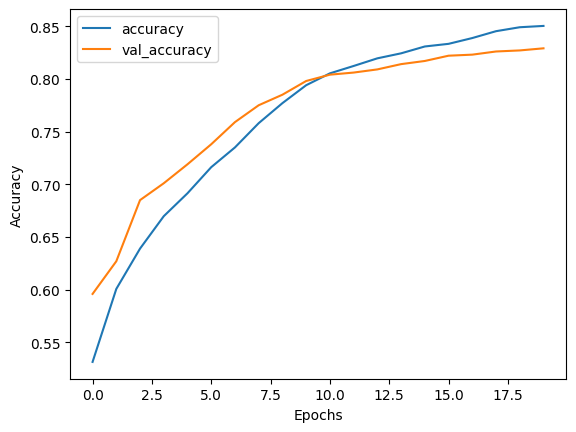

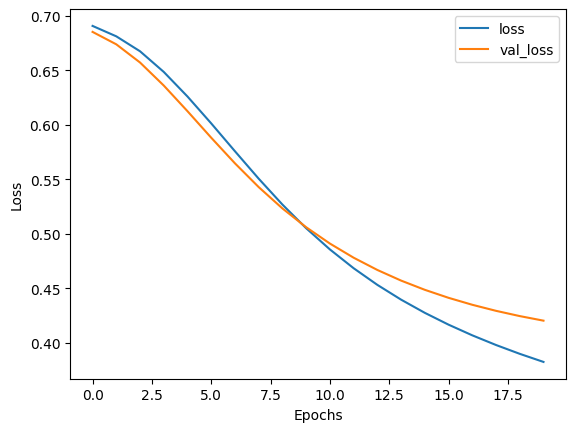

In [29]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f"val_{metric}"])
    plt.show()


plot_metrics(history, "accuracy")
plot_metrics(history, "loss")